## Attribution

Attribution is a problem of answering questions related to how different campaigns are driving conversions. These campaigns can be marketing campaigns, newsletters, notifications etc - essentially any sort of _event_ that _touches_ a user. Hence these events are called _touches_. 

Users often do not convert on the very first time they see an ad or an email campaign. It takes multiple exposures before they finally convert. Hence, not surprisingly, there are different ways to answer this simple question. Some of the common methods to measure attribution are last touch and first touch attribution, where a conversion is attributed to either the very last or the very first touch of a user. But there are other methods too, where multiple touches -those that helped a conversion eventually- get partial credits from a single conversion. More details can be found from this [blog](https://www.rudderstack.com/blog/from-first-touch-to-multi-touch-attribution-with-rudderstack-dbt-and-sagemaker/).

Below, we see the whole process of calculating the attribution values using following approaches:
1. Multi-touch attribution methods:
    * Shapley values
    * Markov Chain Analysis
2. Single touch methods:
    * Firt touch
    * Last touch
    
* Shapley values code is implemented based on the logic presented in this [paper](https://arxiv.org/pdf/1804.05327.pdf)
* Markov chain values are based on the following [whitepaper](https://www.channelattribution.net/pdf/Whitepaper.pdf)

In [1]:
# Loading the required libraries
import json
import boto3
import os
import sys
import time
import gzip
from typing import List, Optional, Union, Dict, Tuple
import datetime

import pandas as pd
import numpy as np

import logging
import yaml
import itertools

from dataclasses import dataclass
from pprint import pprint
from functools import reduce
from pathlib import Path



pd.set_option('display.max_columns', None)

from tqdm import tqdm
tqdm.pandas()

### Part I: CONFIG:

Loading configs

In [2]:
# Parameters cell for papermill. These values can get overridden by parameters passed by papermill
run_id = str(int(time.time()))
folder_utils_path = None # "/opt/ml/processing/input/code/")
local_output_path = "data"

In [3]:
if run_id:
    run_id = str(run_id)

In [4]:
if folder_utils_path:
    sys.path.append(folder_utils_path)
    
from utils import create_logger
from load_data import *
from models import *

In [5]:
IMAGE_FORMAT = 'png'
try:
    logging = create_logger(os.path.join("logs","multi_touch_attribution.log"))
except Exception as e:
    #print(str(e))
    pass

logging.info("\n\n\t\tSTARTING FEATURE PREPROCESSING")

In [6]:
if folder_utils_path is None:
    logging.info("Running locally")
    mode = "local"
    config_path = "config/analysis_config.yaml"
else:
    logging.info("Running inside a container")
    mode = "container"
    config_path = "/opt/ml/processing/code/config/analysis_config.yaml"
    
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

print("Config used:")
pprint(config)

Config used:
{'analysis': {'min_event_interval_in_sec': 300},
 'data': {'conversion_event_name': 'subscription invoice',
          'events_column_name': 'touch_point',
          'filter_columns': ['rudder_id', 'touch_point', 'timestamp'],
          'group_events': False,
          'group_events_mapping': None,
          'ignore_events': [],
          'min_date': '2022-01-01',
          'n_top_events': 14,
          'primary_key_column': 'rudder_id',
          'timestamp_column_name': 'timestamp'},
 'mode': {'container': {'wh_credentials_path': '/opt/ml/processing/config/credentials.yaml'},
          'local': {'wh_credentials_path': 'credentials.yaml'}}}


In [7]:
print(f"Mode used: {mode}")
with open(config["mode"][mode]["wh_credentials_path"], "r") as f:
    creds = yaml.safe_load(f)

Mode used: local


### Part II: Data Preprocessing:

In [8]:
database = creds["data_warehouse"].get("database")
schema = creds["data_warehouse"].get("schema")
table = creds["data_warehouse"].get("feature_registry_table")
results_table = creds["data_warehouse"].get("prediction_output_table_name")

#Read configurations for data preparation
min_date = config["data"]["min_date"]
ignore_events = config["data"]["ignore_events"]

primary_key_column = config["data"]["primary_key_column"]
events_column_name = config["data"]["events_column_name"]
timestamp_column_name = config["data"]["timestamp_column_name"]

# Once data is loaded, these are used in the notebook to do data transformations and cleanup
conversion_event_name = config["data"]["conversion_event_name"]
group_events = config["data"]["group_events"]
group_events_mapping = config["data"]["group_events_mapping"]
filter_columns = config["data"]["filter_columns"]
min_event_interval_in_sec = config["analysis"]["min_event_interval_in_sec"]

if group_events_mapping:
    events_type_mapping = reduce(lambda x, y: {**x,**y}, [{val:key for val in list_vals} for key, list_vals in group_events_mapping.items()])
else:
    events_type_mapping = None

In [9]:
# All the output files get stored in the output_directory. Each run of the feature_processing generates a new sub directory based on the timestamp.
# output directory structure
# - data
#   - <run_id>
#      

output_directory = os.path.join(local_output_path, run_id)

logging.info(f"All the output files will be saved to following location: {output_directory}")
Path(output_directory).mkdir(parents=True, exist_ok=True)


In [10]:
logging.info(f"WH multi touch data config: database: {database}, schema: {schema}, table: {table}")
table_name =  f"{database}.{schema}.{table}"
print(f"Following table from warehouse is being used to read the user touches: {table_name}")

Following table from warehouse is being used to read the user touches: rudderdw.rudder.qry_rs_attribution_v1


## Getting data from the warehouse

In [11]:
def prepare_query(entity_key_col: str,
                  event_col: str,
                  ts_col: str,
                  table_name: str, 
                  ignore_events_list: Optional[List[str]]=None,
                  start_date: Optional[str]=None, 
                  extra_cols_list: Optional[List[str]]=None) -> str:
    all_columns = [entity_key_col, event_col, ts_col]
    if extra_cols_list is not None:
        all_columns = all_columns + extra_cols_list
    all_columns_str = ', '.join(all_columns)
    query = f"select {all_columns_str} from {table_name}"
    conditions = []
    if ignore_events_list is not None and len(ignore_events_list) > 0:
        ignore_events_substr = ", ".join([f"'{e}'" for e in ignore_events_list])
        ignore_events_cond = f"{event_col} not in ({ignore_events_substr})"
        conditions.append(ignore_events_cond)

    if start_date is not None:
        min_date_cond = f"{ts_col} >= '{start_date}'"
        conditions.append(min_date_cond)
        
    conditions_str = ' and '.join(conditions)
    if conditions_str:
        return f"{query} where {conditions_str}"
    else:
        return query
    

# Test cases:
assert prepare_query('user_id', 'event_name','ts', 'table') == 'select user_id, event_name, ts from table'
assert prepare_query('user_id', 'event_name','ts', 'table', ['v1','v2']) == "select user_id, event_name, ts from table where event_name not in ('v1', 'v2')"
assert prepare_query('user_id', 'event_name','ts', 'table', 
                     ['v1','v2'], '2022-02-02') == "select user_id, event_name, ts from table where event_name not in ('v1', 'v2') and ts >= '2022-02-02'"

assert prepare_query('user_id', 'event_name','ts', 'table', None, '2022-02-02') == "select user_id, event_name, ts from table where ts >= '2022-02-02'"

In [12]:

query = prepare_query(primary_key_column, events_column_name, timestamp_column_name, table_name, ignore_events, min_date)
print(f"Following query reads all the necessary data from the warehouse:\n\t{query}")

Following query reads all the necessary data from the warehouse:
	select rudder_id, touch_point, timestamp from rudderdw.rudder.qry_rs_attribution_v1 where timestamp >= '2022-01-01'


In [13]:
wh_conn = Connector(creds["data_warehouse"])

In [14]:
%%time
raw_data = wh_conn.run_query(query)

CPU times: user 1.75 s, sys: 1.14 s, total: 2.89 s
Wall time: 2min 56s


Sample data of the raw data from warehouse, fetched using the above query.

In [15]:
raw_data.head()

,rudder_id,touch_point,timestamp
0,107334,subscription invoice,2022-01-01 00:39:47
1,34166,subscription invoice,2022-01-01 00:48:24
2,119615,subscription invoice,2022-01-01 01:28:08
3,4024,subscription invoice,2022-01-01 01:41:22
4,32614,subscription invoice,2022-01-01 01:52:57


In [16]:
print(f"No:of data points in the raw table: {len(raw_data)}")

No:of data points in the raw table: 467238


In [17]:
print(f"In this table, all rows with the value of '{conversion_event_name}' in the column {events_column_name} are considered as conversion events. Rest all are considered as touches")

In this table, all rows with the value of 'subscription invoice' in the column touch_point are considered as conversion events. Rest all are considered as touches


In [18]:
conversion_timestamps = raw_data.query(f"{events_column_name}=='{conversion_event_name}'").groupby(primary_key_column)[timestamp_column_name].min()

In [19]:
converted_ts_col = f"converted_{timestamp_column_name}"

event_data = (raw_data
              .query(f"{events_column_name}!='{conversion_event_name}'")
              .merge(conversion_timestamps, 
                     how="left", 
                     left_on=primary_key_column, 
                     right_index=True)
              .rename(columns={f"{timestamp_column_name}_x": timestamp_column_name, f"{timestamp_column_name}_y": converted_ts_col})
              .query(f"{converted_ts_col}.isnull() or {timestamp_column_name}<={converted_ts_col}", engine="python")
              .drop_duplicates()
             )

print(f"No:of data points after some basic clean up such as de-duplicating, and separating out conversion events: {len(event_data)}")

No:of data points after some basic clean up such as de-duplicating, and separating out conversion events: 403519


Following are the touches related data:

In [20]:
print(f"Distinct touches count: {len(event_data[events_column_name].value_counts())}")

Distinct touches count: 48


Top 20 touches by percentage:

In [28]:
pd.DataFrame(event_data[events_column_name].value_counts(normalize=True).head(20).round(4)*100).reset_index()

,index,touch_point
0,reviews,80.88
1,16654213127,5.35
2,comments,3.85
3,16871110236,1.60
4,StatPearls_TrendMD_0,1.58
5,15536766452,1.29
6,16883466899,1.03
7,16252805407,0.87
8,14414726879,0.81
9,15442295175,0.78


In [29]:
def get_top_k_touches(df: pd.DataFrame, event_col: str, top_k: Optional[int]=None) -> pd.DataFrame:
    """
    Picks only the top k touches and groups rest all as 'others'. If 'others' is one of the events, it appends that with current epoch time
    """
    if top_k is None:
        return df
    else:
        top_k_events = list(df[event_col].value_counts().head(top_k).index)
        all_events = list(df[event_col].value_counts().index)
        default_event = 'others'
        if default_event in all_events:
            curr_time = int(time.time())
            while f"{default_event}_{curr_time}" in all_events:
                curr_time+=1
            default_event = f"{default_event}_{curr_time}"
        df[event_col] =  df[event_col].apply(lambda event: event if event in top_k_events else default_event)
    return df


# Test cases:
test_df = pd.DataFrame.from_dict({"uid":[1,2,3],"event":['e1','e1','e2']})
assert (get_top_k_touches(test_df, 'event') == test_df ).all().all()
assert (get_top_k_touches(test_df, 'event',1) ==  pd.DataFrame.from_dict({"uid":[1,2,3],"event":['e1','e1','others']})).all().all()

test_df = pd.DataFrame.from_dict({"uid":[1,2,3],"event":['e1','e1','others']})

assert (get_top_k_touches(test_df, 'event',1) ==  pd.DataFrame.from_dict({"uid":[1,2,3],"event":['e1','e1',f'others_{int(time.time())}']})).all().all()

curr_time = int(time.time())
test_df = pd.DataFrame.from_dict({"uid":[1,2,3,4],"event":['e1','e1','others',f'others_{curr_time}']})

try:
    assert (get_top_k_touches(test_df, 'event',1) ==  pd.DataFrame.from_dict({"uid":[1,2,3,4],"event":['e1','e1',f'others_{curr_time+1}',f'others_{curr_time+1}']})).all().all()
except AssertionError:
    print(test_df)

In [30]:
%%time
if config["data"]["n_top_events"] is not None:
    n_top_k_events = config["data"]["n_top_events"]
    print("Having too many touches would make calculating Shapley values challenging, and also make it difficult to interpret the results.")
    print(f"So, as a default option, only the top {n_top_k_events} events by vol are considered. Rest are all grouped as one single touch type. This behavior can be modified from the config file.")
    event_data = get_top_k_touches(event_data, events_column_name, n_top_k_events)
    print(f"Percent touches replaced by default value: {event_data[events_column_name].value_counts(normalize=True)['others'] * 100:.2f} %")

Having too many touches would make calculating Shapley values challenging, and also make it difficult to interpret the results.
So, as a default option, only the top 14 events by vol are considered. Rest are all grouped as one single touch type. This behavior can be modified from the config file.
Percent touches replaced by default value: 0.45 %
CPU times: user 222 ms, sys: 3.85 ms, total: 226 ms
Wall time: 225 ms


In [31]:
# Transformations on the raw data. We apply the constraints defined in the constants cell above.

def dedup_by_ts_delta(df: pd.DataFrame, primary_key: str, timestamp: str, event_type: str, max_lag: int) -> pd.DataFrame:
    """
    ### Parameters
    1. df : pd.DataFrame
        - User touches dataframe. 
    2. primary_key : str
        - column name of the column that contains user_id. 
    3. timestamp: str
        - column name of the column that contains event timestamp
    4. event_type: str
        - column name of the column that contains event/touch data
    5. max_lag: int
        - max time (in sec) between consecutive events to be considered as duplicates. 

    ### Returns
    - DataFrame after doing following steps
    Based on primary key and event_type, it checks if two consecutive events occur within the max_lag time window. If so, they are considered same event and the latter event is dropped. 
    """
    if max_lag <= 0:
        return df
    df = df.sort_values(by=[primary_key, timestamp], ascending=True).reset_index(drop=True)
    original_columns = df.columns
    df[f"prev_{primary_key}"] = df[primary_key].shift()
    df[f"prev_{event_type}"] = df[event_type].shift()
    df[f"prev_{timestamp}"] = df[timestamp].shift()

    def is_duplicate(row):
        if pd.isnull(row[f"prev_{primary_key}"]) or pd.isnull(row[f"prev_{event_type}"]) or pd.isnull(row[f"prev_{timestamp}"]):
            return False
        elif row[primary_key] == row[f"prev_{primary_key}"] and row[event_type] == row[f"prev_{event_type}"] and (
                row[timestamp] - row[f"prev_{timestamp}"]).total_seconds() <= max_lag:
            return True
        else:
            return False

    df["is_duplicate"] = df.progress_apply(is_duplicate, axis=1)
    return df.query("is_duplicate==False")[original_columns].reset_index(drop=True)

def process_raw_data(raw_data_df: pd.DataFrame,
                     dedup_min_time: int,
                     reduce_touches: bool = True) -> pd.DataFrame:
    """
    ### Parameters
    1. raw_data_df : Raw data 
    2. ignore_touches: Ignores the touches present in this list. 
    3. min_date: Ignores events before this date
    4. dedup_min_time: Time (in sec) between two events of same type. Events that repeat within this interval are combined as one (earlier timestamp is considered)
    5. reduce_touches : Whether to combine touchpoints based on their logical groupings

    ### Returns
    - DataFrame after doing following steps
    1. Groups tracks pages if reduce_touches flag is True
    2. Deduplicates based on 5 min interval 
    3. Ignores touches based on ignore_touches list
    4. Ðrops events before the min_date timestamp.
    """
    if reduce_touches:
        raw_data_df[events_column_name] = raw_data_df[events_column_name].apply(lambda touch: events_type_mapping.get(touch, touch))
    
    dedup_data_df = (dedup_by_ts_delta(raw_data_df
                                       .query(f"~{events_column_name}.isnull()",engine='python')
                                       .drop_duplicates(),
                                       primary_key_column,
                                       timestamp_column_name, 
                                       events_column_name, 
                                       dedup_min_time)
                     .filter(filter_columns)
                    )
    return dedup_data_df.query(f'{events_column_name} not in @ignore_events', engine='python')

In [32]:
touch_data_filtered = process_raw_data(event_data, min_event_interval_in_sec, group_events)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 403518/403518 [00:14<00:00, 27930.15it/s]


CPU times: user 15.4 s, sys: 323 ms, total: 15.8 s
Wall time: 15.8 s


In [33]:
touch_data_filtered[converted_ts_col] = touch_data_filtered[primary_key_column].apply(lambda entity: conversion_timestamps.get(entity))
touch_data_filtered["is_converted"] = touch_data_filtered[primary_key_column].apply(lambda entity: 1 if entity in conversion_timestamps else 0)

In [34]:
# Sample data:
touch_data_filtered.head()

,rudder_id,touch_point,timestamp,converted_timestamp,is_converted
0,00003dfc-d2d5-483e-8017-01787cb66454,reviews,2022-05-30 01:17:36.910,NaT,0
1,00014260-d6a7-4e5e-8506-90c51d659135,reviews,2022-06-15 17:49:55.747,NaT,0
2,00016323-c71f-43ba-a0cf-dbadce542b0d,comments,2022-07-05 18:29:31.654,NaT,0
3,0002b55f-5701-4edc-9d9f-c8e911496f1f,reviews,2022-05-05 15:12:59.819,NaT,0
4,0002efc9-0285-444a-9491-e2c5794544b3,reviews,2022-03-15 21:13:26.873,NaT,0


In [35]:
positive_touchpoints = touch_data_filtered.query("is_converted==1", engine='python')
negative_touchpoints = touch_data_filtered.query("is_converted==0", engine='python')

print("Summary stats on converted and non converted journeys:\n")
print(f"Total rows (events/touches) in converted journeys: {len(positive_touchpoints)}")
print(f"Distinct converted journeys: {len(positive_touchpoints[primary_key_column].unique())}\n")
print(f"Total rows (events/touches) in non-converted journeys: {len(negative_touchpoints)}")
print(f"Distinct non-converted journeys: {len(negative_touchpoints[primary_key_column].unique())}")


Summary stats on converted and non converted journeys:

Total rows (events/touches) in converted journeys: 1450
Distinct converted journeys: 987

Total rows (events/touches) in non-converted journeys: 269363
Distinct non-converted journeys: 235393


### Part III: Data distribution (Optional)

A few stats on the converted journeys before going into the actual attribution problem:

Note: This section is not required to calculate the attribution values. Instead, it is just to show the distribution of no:of events and no:of days before users convert. You can skip directly to [Part IV](#MTA-Calculations-begin)

In [36]:
conversion_summary = positive_touchpoints.groupby([primary_key_column]).agg({timestamp_column_name: "min", events_column_name:["size", "nunique"]}).reset_index()
col_n_events = f"n_{events_column_name}"
col_n_distinct_events = f"n_distinct_{events_column_name}"

conversion_summary.columns = [primary_key_column, timestamp_column_name, col_n_events, col_n_distinct_events]
conversion_summary["days_to_convert"] = conversion_summary.apply(lambda row: (conversion_timestamps.get(row[primary_key_column]) - row[timestamp_column_name]).days, axis=1)

print("Sample user level summary of no:of events and no:of days to convert:")
conversion_summary.head()

Sample user level summary of no:of events and no:of days to convert:


,rudder_id,timestamp,n_touch_point,n_distinct_touch_point,days_to_convert
0,100127,2022-03-07 20:30:25.564,2,1,103
1,100128,2022-02-01 04:32:25.444,1,1,71
2,100268,2022-07-02 18:04:11.469,1,1,0
3,100315,2022-03-24 13:10:56.825,2,1,14
4,100494,2022-03-01 21:34:57.373,1,1,41


In the below images, the distribution of conversions is shown - first based on the no:of total events before conversion, and the second one based on no:of days since first seen.

The x-axis of days since first seen plot is capped at 100 days by default. It can be modifid by changing the variable `MAX_CONVERSION_DAYS` in the code cell.

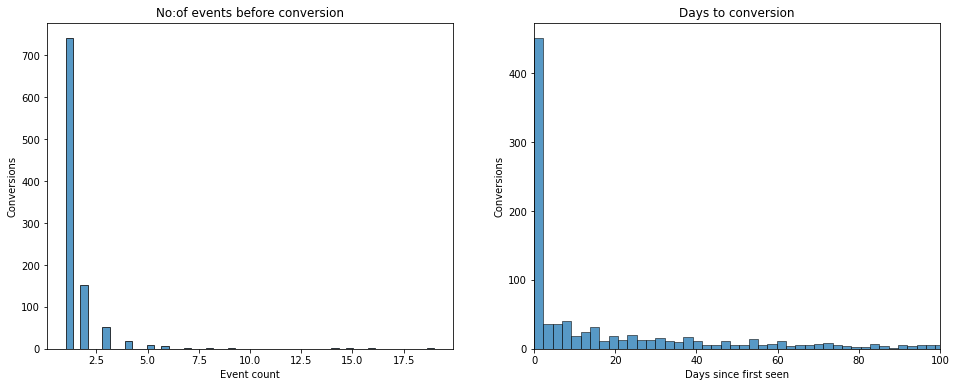

In [37]:
MAX_CONVERSION_DAYS=100 # This is used only for visualizing below, and does not have any other affect.

fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.histplot(conversion_summary[col_n_events], bins=50, ax=axs[0])
axs[0].set_title("No:of events before conversion")
axs[0].set_ylabel("Conversions")
axs[0].set_xlabel("Event count");

sns.histplot(conversion_summary["days_to_convert"], bins=70, ax=axs[1])
axs[1].set_title("Days to conversion")
axs[1].set_ylabel("Conversions")
axs[1].set_xlim([0,MAX_CONVERSION_DAYS])
axs[1].set_xlabel("Days since first seen");

plt.savefig(os.path.join(output_directory, f"data_distribution.{IMAGE_FORMAT}"))

In [38]:
# Checks percentile counts at various levels. Can modify this list to get a different percentile value (ex: For 90th percentile, add 90 to the list.)
percentile_points = [0,5, 25, 50, 75, 95, 99, 100]

In [39]:
print(f"Avg no:of touches before a user converts: \n\nMean: {conversion_summary[col_n_events].mean():.2f}\nMedian: {np.median(conversion_summary[col_n_events])}")
print("\nPercentiles for No:of touches:")
(pd.DataFrame.from_dict(
    dict(zip(percentile_points, 
             np.percentile(conversion_summary[col_n_events],
                           percentile_points).round())),
    orient='index', 
    columns=[col_n_events])
 .reset_index().rename(columns={"index":"percentile"}))

Avg no:of touches before a user converts: 

Mean: 1.47
Median: 1.0

Percentiles for No:of touches:


,percentile,n_touch_point
0,0,1.0
1,5,1.0
2,25,1.0
3,50,1.0
4,75,1.0
5,95,3.0
6,99,6.0
7,100,19.0


In [40]:
print(f"Avg days to convert:\n\nMean:{conversion_summary['days_to_convert'].mean():.2f}\nMedian: {np.median(conversion_summary['days_to_convert'])}")
print("\nPercentiles for No:of days to convert:")
(pd.DataFrame.from_dict(
    dict(zip(percentile_points, 
             np.percentile(conversion_summary['days_to_convert'],
                           percentile_points).round())),
    orient='index', 
    columns=['n_days_to_convert'])
 .reset_index().rename(columns={"index": "percentile"}))

Avg days to convert:

Mean:21.92
Median: 5.0

Percentiles for No:of days to convert:


,percentile,n_days_to_convert
0,0,0.0
1,5,0.0
2,25,0.0
3,50,5.0
4,75,32.0
5,95,98.0
6,99,127.0
7,100,161.0


### Part IV: Data transformation:

Converting data to the required format for calculating attribution values

In [41]:
## Helper function to transform data to the required input form 

def collect_touchpoints(touchpoints_df: pd.DataFrame, 
                        primary_key: str=primary_key_column, 
                        ts_column: str=timestamp_column_name,
                        touchpoint_column: str=events_column_name) -> pd.DataFrame:
    """
    Transform dataframe with each touch as a row to a new dataframe where each journey has a single row with all touches as a list in chronological order
    touchpoints_df: A dataframe with each row corresponding to a touch. 
    primary_key: Name of the column containing unique user identifier
    ts_column: Name of column containing timestamp using which journeys are sorted chronologically
    touchpoint_column: Name of column containing touch points. 
    
    Returns:
    A dataframe with two columns, first has primary key and second has the touchpoint_column
    """
    return (touchpoints_df
            .sort_values(by=[primary_key, ts_column], 
                         ascending=True)
            .reset_index(drop=True)
            .groupby(primary_key)[touchpoint_column]
            .apply(list)
            .reset_index())


In [42]:
touchpoints_list_pos = collect_touchpoints(positive_touchpoints)
touchpoints_list_neg = collect_touchpoints(negative_touchpoints)

touchpoints_list_pos.head()

,rudder_id,touch_point
0,100127,"[reviews, reviews]"
1,100128,[reviews]
2,100268,[16654213127]
3,100315,"[reviews, reviews]"
4,100494,[reviews]


In [43]:
len(touchpoints_list_pos), len(touchpoints_list_neg)

(987, 235393)

<a id='MTA-Calculations-begin'></a>

### Part V: Shapley values calculation


In [44]:
touches_shapley_values = get_shapley_values(touchpoints_list_pos[events_column_name].values, [1] * len(touchpoints_list_pos))

### Part VI: Markov Chain Values Calculation

Index of transition counts: 1st: source, last: destination. 2 to -1: same order as dict_touches_inv keys

In [45]:
all_touches = list(touch_data_filtered[events_column_name].unique())

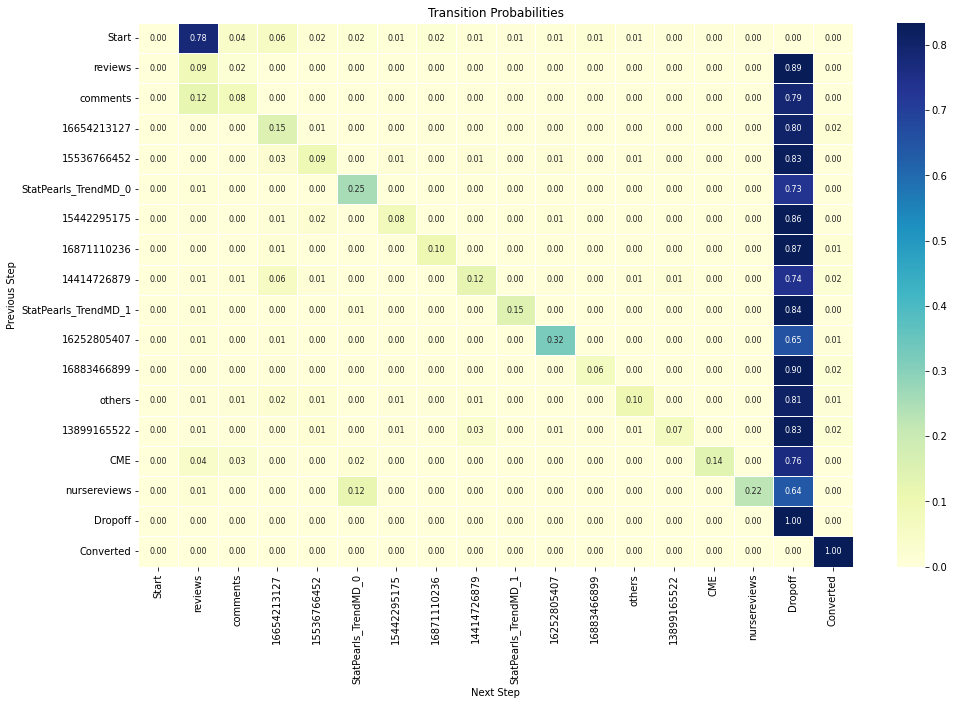

In [46]:
flag_markov = False
try:
    markov_attribution_values, transition_probabilities = get_markov_attribution(touchpoints_list_pos[events_column_name].values, 
                                                                                 touchpoints_list_neg[events_column_name].values, 
                                                                                 all_touches,
                                                                                 visualize=True)

    plt.savefig(os.path.join(output_directory, f"markov_transition_probabilities.{IMAGE_FORMAT}"))
    flag_markov = True
except Exception as e:
    print(e)
    flag_markov = False
    markov_attribution_values = None
    transition_probabilities = None

In the above graphic, we can see the transition probabilities from each touch (Y-axis) to the next touch (X-axis). 

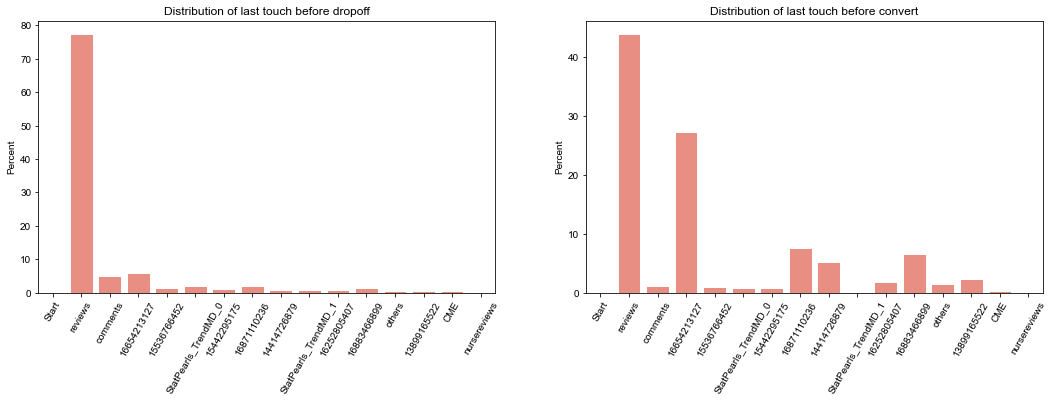

In [47]:
try:
    pos_transitions, labels = generate_transition_counts(touchpoints_list_pos[events_column_name].values, all_touches, is_positive=True)
    neg_transitions, labels = generate_transition_counts(touchpoints_list_neg[events_column_name].values, all_touches, is_positive=False)
    all_transitions = pos_transitions + neg_transitions

    fig, axs=plt.subplots(1,2, figsize=(18, 5))
    sns.set_style("white")
    sns.barplot(x=labels[:-2], y=100*all_transitions[:-2, -2]/all_transitions[:-2, -2].sum(), ci=None, color="salmon", ax=axs[0])

    axs[0].set_xticklabels(labels[:-2],rotation=60)
    axs[0].set_ylabel("Percent")
    axs[0].set_title("Distribution of last touch before dropoff");

    sns.barplot(x=labels[:-2], y=100*all_transitions[:-2, -1]/all_transitions[:-2, -1].sum(), ci=None, color="salmon", ax=axs[1])
    axs[1].set_xticklabels(labels[:-2],rotation=60)
    axs[1].set_ylabel("Percent")
    axs[1].set_title("Distribution of last touch before convert");

    plt.savefig(os.path.join(output_directory, f"distribution_of_last_touch_before_dropoff_and_convert.{IMAGE_FORMAT}"))
except Exception as e:
    print(e)


The left plot above tells the distribution of all the touches immediately before they drop off. All the bars sum up to 100.

The right plot above tells the distribution of all the touches immediately before they convert. All the bars sum up to 100.

### Part VII: Conclusion - Results summary

The attribution values from different methods look as below. 

In [49]:

last_touch_results = get_single_touch_attribution(touchpoints_list_pos, events_column_name, last_touch=True, normalize=False)
first_touch_results = get_single_touch_attribution(touchpoints_list_pos, events_column_name, last_touch=False, normalize=False)

mta_values = merge_dictionaries([touches_shapley_values, markov_attribution_values, last_touch_results, first_touch_results] , ['shap', 'markov', 'last_touch', 'first_touch'])

mta_values

,shap,markov,last_touch,first_touch
13899165522,22.833333,22.727529,22,24.0
14414726879,57.000000,54.269382,52,62.0
15442295175,6.333333,8.113183,7,7.0
15536766452,9.333333,13.214350,9,9.0
16252805407,17.000000,17.046194,17,14.0
16654213127,264.166667,263.179429,269,260.0
16871110236,73.500000,73.019895,74,73.0
16883466899,64.166667,63.283736,65,62.0
CME,2.000000,2.333960,2,2.0
StatPearls_TrendMD_0,8.000000,7.895030,8,7.0


In [74]:
print("In the table, each column shows what the attribution scores for different touches are.\n")

print(f"For example, the first value in the column corresponding to `last_touch` tell how many conversions can be attributed to the touch type '{mta_values.index[0]}'")

In the table, each column shows what the attribution scores for different touches are.

For example, the first value in the column corresponding to `last_touch` tell how many conversions can be attributed to the touch type '13899165522'


In [73]:
print("Each column independently sums to the total number of conversions, as seen below: \n")
mta_values.sum(axis=0)

Each column independently sums to the total number of conversions, as seen below: 



shap           987.0
markov         987.0
last_touch     987.0
first_touch    987.0
dtype: float64

The same data is shown as a visualization below. In it, x-axis has different touches and y-axis has the no:of conversions attributable to each touch. The color of the bar shows what method is used to capture the attribution value. A high attribution score indicates high conversions coming from that touch point. A low score indicates low conversions coming from that touch point. 

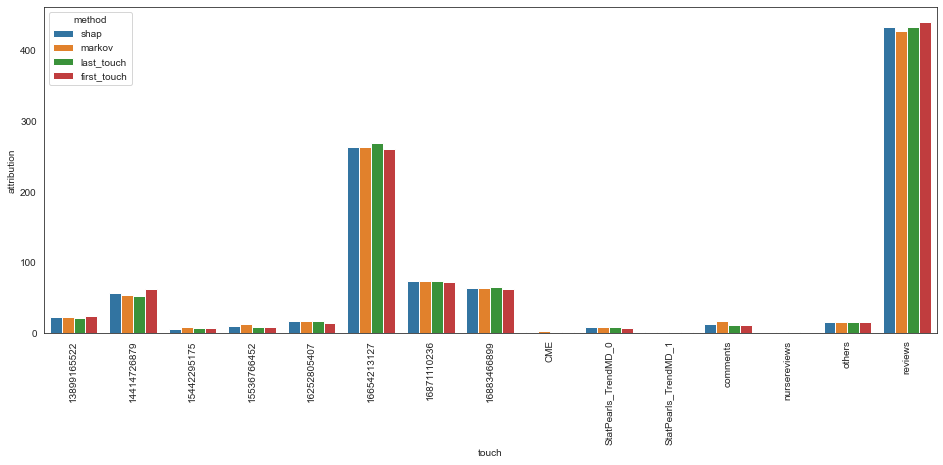

In [76]:
mta_long = pd.melt(mta_values.reset_index(), 'index', list(mta_values))
mta_long.columns = ['touch', 'method', 'attribution']
plt.figure(figsize=(16,6))
sns.barplot(data=mta_long, x='touch',y='attribution',hue='method');
plt.xticks(rotation=90);
plt.savefig(os.path.join(output_directory, f"results_summary.{IMAGE_FORMAT}"))

## Appendix:

The attribution values are already computed above. Below parts are not necessary but rather sanity checks on the robustness of results and how correlated results from different methods are. Going through them is entirely optional to understand the attribution results themselves, and is needed only as a QA on the results. 

**Correlation:**

Correlation between different methods is shown in the below table. If the score is close to 1, that indicates both methods give very similar results, ex, attribution scores using shapley values and markov chain method are very close to each other.

Instead if the score is close to 0, that indicates the two methods give results that are fairly independent of each other. Say, shapley values and markov chain methods have a correlation of 0.05, that indicates the touches deemed important by both methods are very different.

Usually if the number of distinct touches before a conversion is low, the correlation would tend to be high.

In [51]:
mta_values.corr()

,shap,markov,last_touch,first_touch
shap,1.000000,0.999908,0.999890,0.999785
markov,0.999908,1.000000,0.999886,0.999551
last_touch,0.999890,0.999886,1.000000,0.999416
first_touch,0.999785,0.999551,0.999416,1.000000


In [43]:
## ToDo: Writing results back to redshift table is pending. 
# SnowflakeDataIO.write_to_snowflake_table(mta_values, creds["snowflake"]["results_table_name"], creds["snowflake"], if_exists="append")
# print(f'The output data is stored in the warehouse table: {creds["snowflake"]["results_table_name"]}')

In [52]:
print(f"MTA values will be written to the location:\n\t{output_directory}")

MTA values will be written to the location:
	data/1658415209


In [53]:
mta_values.to_parquet(f"{output_directory}/mta_values.parquet")

**Robustness testing**

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
markov_vals = {}
shapley_vals = {}

touchpoints_list_pos_rand1, touchpoints_list_pos_rand2 = train_test_split(touchpoints_list_pos, train_size=0.5)
touchpoints_list_neg_rand1, touchpoints_list_neg_rand2 = train_test_split(touchpoints_list_neg, train_size=0.5)

touches_shapley_values_rand1 = get_shapley_values(touchpoints_list_pos_rand1[events_column_name].values, [1] * len(touchpoints_list_pos_rand1))
# get_shapley_values(touchpoints_list_pos_rand1["event_id"].values, dict_touches, visualize=False)
markov_attribution_values_rand1, _ = get_markov_attribution(touchpoints_list_pos_rand1[events_column_name].values, touchpoints_list_neg_rand1[events_column_name].values, all_touches, visualize=False)

touches_shapley_values_rand2 = get_shapley_values(touchpoints_list_pos_rand2[events_column_name].values, [1] * len(touchpoints_list_pos_rand2))
markov_attribution_values_rand2, _ = get_markov_attribution(touchpoints_list_pos_rand2[events_column_name].values, touchpoints_list_neg_rand2[events_column_name].values, all_touches, visualize=False)


for key, val in touches_shapley_values_rand1.items():
    shapley_vals[key] = [val, touches_shapley_values_rand2.get(key,0)]

for key, val in markov_attribution_values_rand1.items():
    markov_vals[key] = [val, markov_attribution_values_rand2.get(key,0)]

    
shapley_vals_df = pd.DataFrame.from_dict(shapley_vals, orient='index')
markov_vals_df = pd.DataFrame.from_dict(markov_vals, orient='index')
print(f"Correlation of shapley values between two non-overlapping splits: {shapley_vals_df.corr()[0][1]:.3f}")
print(f"Correlation of markov values between two non-overlapping splits: {markov_vals_df.corr()[0][1]:.3f}")

Correlation of shapley values between two non-overlapping splits: 0.993
Correlation of markov values between two non-overlapping splits: 0.994


In [56]:
shapley_vals_df = pd.melt(shapley_vals_df.reset_index(), id_vars='index')
shapley_vals_df.columns = ['touch', 'iter', 'shap']

markov_vals_df = pd.melt(markov_vals_df.reset_index(), id_vars='index')
markov_vals_df.columns = ['touch', 'iter', 'markov']

tp_order = shapley_vals_df.groupby('touch')['shap'].mean().reset_index().sort_values("shap", ascending=False)['touch'].values

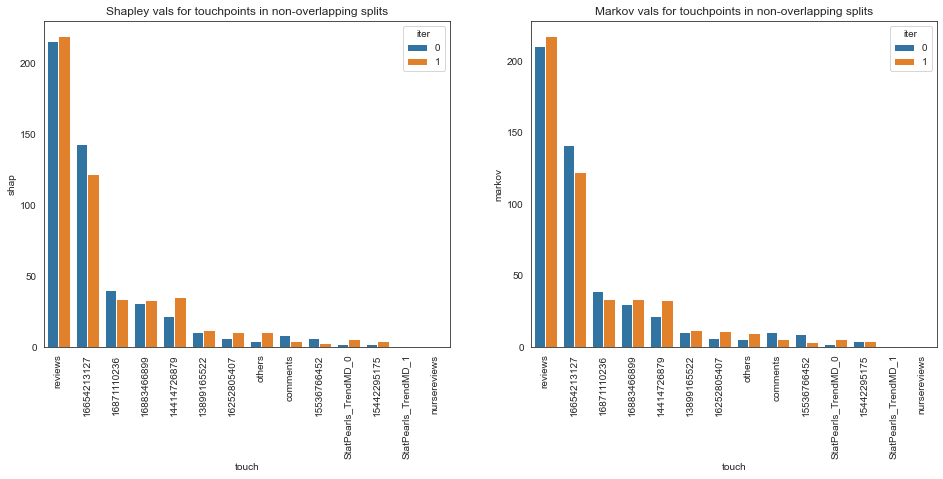

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(x='touch', y='shap', hue='iter', data=shapley_vals_df, ax=axs[0], order=tp_order)
for item in axs[0].get_xticklabels():
    item.set_rotation(90)
axs[0].set_title("Shapley vals for touchpoints in non-overlapping splits");

sns.barplot(x='touch', y='markov', hue='iter', data=markov_vals_df, ax=axs[1], order=tp_order)
for item in axs[1].get_xticklabels():
    item.set_rotation(90)
axs[1].set_title("Markov vals for touchpoints in non-overlapping splits");

plt.savefig(os.path.join(output_directory, f"shapley_markov_values_non_overlapping_splits.{IMAGE_FORMAT}"))

In [58]:
markov_vals = {}
shapley_vals = {}
for iters in range(10):
    touchpoints_list_pos_rand, _ = train_test_split(touchpoints_list_pos, train_size=0.7)
    touchpoints_list_neg_rand, _ = train_test_split(touchpoints_list_neg, train_size=0.7)
    touches_shapley_values_rand = get_shapley_values(touchpoints_list_pos_rand[events_column_name].values, [1] * len(touchpoints_list_pos_rand))
    markov_attribution_values_rand, _ = get_markov_attribution(touchpoints_list_pos_rand[events_column_name].values, touchpoints_list_neg_rand[events_column_name].values, all_touches, visualize=False)
    for touch, shap in touches_shapley_values_rand.items():
        curr = shapley_vals.get(touch, [])
        curr.append(shap)
        shapley_vals[touch] = curr
    for touch, mark in markov_attribution_values_rand.items():
        curr = markov_vals.get(touch, [])
        curr.append(mark)
        markov_vals[touch] = curr

In [59]:
shapley_ranks = pd.DataFrame.from_dict(shapley_vals, orient='index').fillna(0).rank(axis=0, ascending=False).astype(int)
markov_ranks = pd.DataFrame.from_dict(markov_vals, orient='index').fillna(0).rank(axis=0, ascending=False).astype(int)

In [60]:
def df_to_heatmap(df:pd.DataFrame, title:str)->None:
    ax = sns.heatmap(df.sort_values(by=0),
                     linewidths=0.5,
                     robust=True, 
                     annot_kws={"size":10}, 
                     annot=True,
                     fmt="d",
                     cmap="YlGnBu",
                     cbar=False)
    ax.tick_params(labelsize=14)
    ax.figure.set_size_inches((10, 6))
    ax.set_xlabel("Iteration")
    ax.set_title(title);
    plt.show()

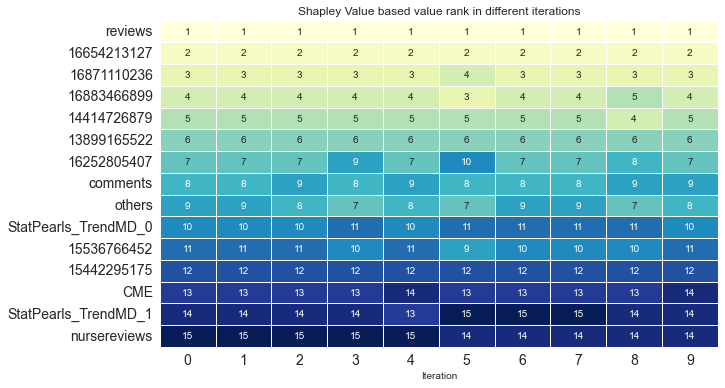

In [61]:
df_to_heatmap(shapley_ranks,"Shapley Value based value rank in different iterations")

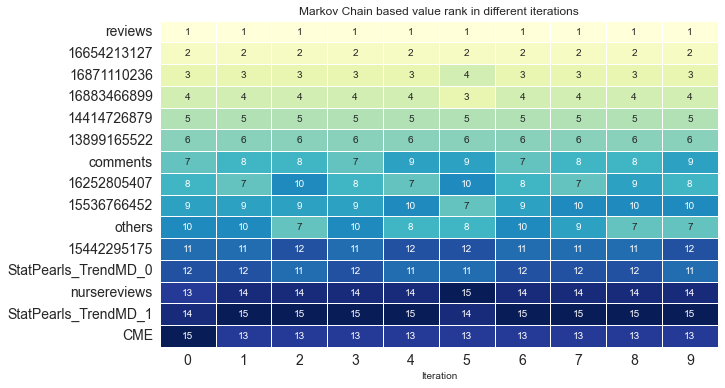

In [62]:
df_to_heatmap(markov_ranks,"Markov Chain based value rank in different iterations")

In the above two heatmaps, each row shows the rank of that respective touch, within each iteration. If the methods are stable, the ranks don't change much. Some variations are expected, especially when the converted journeys are small in number.

In [63]:
logging.info("Done")

In [64]:
## Cell to hide code while converting to a html page
from IPython.display import HTML

HTML('''<script>
$('div.input').hide();
</script>''')